In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn

import torchvision
import torchvision.transforms as transforms

import pandas as pd
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import numpy as np
import os
from time import sleep

from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 32
RANDOM_SEED = 123

cuda


In [2]:
# Build dataset from csv files
class AwareDataset(torch.utils.data.Dataset):
    def __init__(self, csv_data, csv_outcome, csv_verbose, root_dir, train=True, target_classes=None, transform=None):
        self.data_raw = pd.read_csv(csv_data, header=None)
        self.data_out = pd.read_csv(csv_outcome)
        self.data_verb = pd.read_csv(csv_verbose)
        self.root_dir = root_dir
        self.transform = transform
        
        if target_classes != None:
            idx = False
            for i in target_classes:
                idx |= (self.data_out.Diagnosis==i)
            self.data_raw = self.data_raw[idx]
            self.data_out = self.data_out[idx]
            self.data_verb = self.data_verb[idx]
        
        if len(self.data_raw) != len(self.data_out) or len(self.data_raw) != len(self.data_verb):
            raise Exception("Inconsistent data length")
            
        idx = list(range(0,len(self.data_raw)))
        rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
        train_idx, test_idx = next(rs.split(idx))
        if train:
            self.data_raw = self.data_raw.iloc[train_idx]
            self.data_out = self.data_out.iloc[train_idx]
            self.data_verb = self.data_verb.iloc[train_idx]
        else:
            self.data_raw = self.data_raw.iloc[test_idx]
            self.data_out = self.data_out.iloc[test_idx]
            self.data_verb = self.data_verb.iloc[test_idx]

    def __len__(self):
        return len(self.data_raw)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data_raw.iloc[idx, 34:118].values.astype('float32')
        data = (data-np.mean(data))/np.std(data)
        target = self.data_out.iloc[idx, :].values.astype('float32')
        verbose = self.data_verb.iloc[idx, :].values.astype('float32')

        return data, target, verbose


trainset = AwareDataset(csv_data = 'data/exhale_data_v5_ave.csv',
                        csv_outcome = 'data/exhale_outcome_v5_ave.csv',
                        csv_verbose = 'data/exhale_verbose_v5_ave.csv',
                        root_dir = 'data/',
                        train = True,
                        target_classes = [1,2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = AwareDataset(csv_data = 'data/exhale_data_v5_ave.csv',
                       csv_outcome = 'data/exhale_outcome_v5_ave.csv',
                       csv_verbose = 'data/exhale_verbose_v5_ave.csv',
                       root_dir = 'data/',
                       train = False,
                       target_classes = [1,2])
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

# dataiter = iter(trainloader)
# inputs, labels, info = dataiter.next()
# print(inputs.size())
# print(labels[0])
# plt.plot(inputs[0])
# plt.ylim([-5,5])

In [3]:
from models.AE import Net
model = Net()
print(model)
model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

Net(
  (encoder): Sequential(
    (0): Linear(in_features=84, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=48, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=84, bias=True)
  )
)


In [4]:
best_acc = 0  # best test accuracy

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

writer = SummaryWriter()

def train(epoch):
#     clear_output(wait=False)
    print('Epoch: %d | TRAIN' % epoch)
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0
    for batch_idx, (inputs, labels, info) in enumerate(trainloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
#         inputs_prep = F.dropout(inputs, p=0.2)*0.8  # Random zeroing
        outputs = model(inputs)
#         outputs = model(inputs_prep)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += labels.size(0)
        
        print('Batch: %d/%d | Loss: %.3f'
              % (batch_idx+1, len(trainloader), train_loss/(batch_idx+1)), end='\r')
        
    writer.add_scalar('Loss/train', train_loss/(batch_idx+1), epoch)
        
def test(epoch):
    global best_loss
    best_loss = 1e8
    clear_output(wait=False)
    print('Epoch: %d | TEST' % epoch)
    model.eval()
    test_loss = 0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels, info) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            test_loss += loss.item()
            total += labels.size(0)
            
            print('Batch: %d/%d | Loss: %.3f'
                  % (batch_idx+1, len(testloader), test_loss/(batch_idx+1)), end='\r')
        
    writer.add_scalar('Loss/test', test_loss/(batch_idx+1), epoch)
    
    # Save checkpoint.
    current_loss = test_loss/(batch_idx+1)
    if current_loss < best_loss:
        print('Saving.. | Loss: %.3f\n' % current_loss)
        state = {
            'net': model.state_dict(),
            'loss': current_loss,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_loss = current_loss

In [5]:
for epoch in range(200):
    train(epoch)
    test(epoch)
#     scheduler.step()

os.rename('./checkpoint/ckpt.pth', f'./checkpoint/ckpt_{best_loss:.2f}.pth')

Epoch: 199 | TEST
Saving.. | Loss: 0.02424



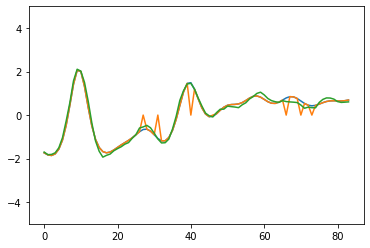

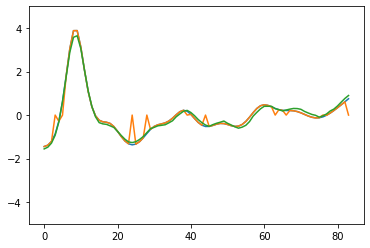

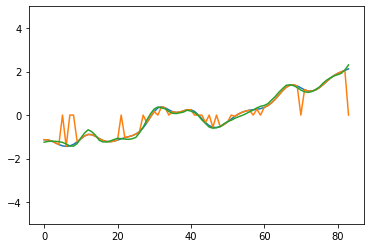

In [6]:
with torch.no_grad():
    dataiter = iter(testloader)
    inputs, labels, info = dataiter.next()
    inputs = inputs.to(device)
    inputs_prep = F.dropout(inputs, p=0.2)*0.8  # Random zeroing
    outputs = model(inputs)
#     outputs = model(inputs_prep)
    print('\n')
    plt.plot(inputs[0].cpu().numpy())
    plt.plot(inputs_prep[0].cpu().numpy())
    plt.plot(outputs[0].cpu().numpy())
    plt.ylim([-5,5])
    plt.show()
    
    plt.plot(inputs[1].cpu().numpy())
    plt.plot(inputs_prep[1].cpu().numpy())
    plt.plot(outputs[1].cpu().numpy())
    plt.ylim([-5,5])
    plt.show()
    
    plt.plot(inputs[2].cpu().numpy())
    plt.plot(inputs_prep[2].cpu().numpy())
    plt.plot(outputs[2].cpu().numpy())
    plt.ylim([-5,5])
    plt.show()
    
encoder = model.encoder
state = {
    'net': encoder.state_dict(),
    'loss': best_loss,
    'epoch': epoch,
}
torch.save(state, f'./checkpoint/encoder_{best_loss:.2f}.pth')

In [7]:
best_loss

0.02415157699336608

In [8]:
print(inputs.size())
tmp = torch.cat((inputs,inputs),1)
print(tmp.size())

torch.Size([32, 84])
torch.Size([32, 168])
